## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp_after_input_layer(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
#             x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
#             x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    model.name = 'model2'
    return model

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
#             x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
#             x = BatchNormalization()(x)
    x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    model.name = 'model'
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256 ]
MOMENTUM = 0.95

In [7]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
def batch_test(model, BATCH_SIZE):
    results = {}
    for b_size in BATCH_SIZE:
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=b_size, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_name_tag = "%s-%s" % (model.name, str(b_size))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}       
    return results

In [8]:
model  = build_mlp(input_shape=x_train.shape[1:])
model2 = build_mlp_after_input_layer(input_shape=x_train.shape[1:])

In [9]:
results = batch_test(model, BATCH_SIZE)
results2 = batch_test(model2, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,739,402
Trainable params: 1,739,146
Non-trainable params: 256
________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 531us/step - loss: 2.1691 - acc: 0.1758 - val_loss: 2.1484 - val_acc: 0.1805
Epoch 2/50
50000/50000 [==============================] - 26s 514us/step - loss: 2.1659 - acc: 0.1814 - val_loss: 2.1455 - val_acc: 0.1867
Epoch 3/50
50000/50000 [==============================] - 25s 507us/step - loss: 2.1624 - acc: 0.1845 - val_loss: 2.1428 - val_acc: 0.1898
Epoch 4/50
50000/50000 [==============================] - 26s 518us/step - loss: 2.1600 - acc: 0.1867 - val_loss: 2.1389 - val_acc: 0.1949
Epoch 5/50
50000/50000 [==============================] - 25s 503us/step - loss: 2.1557 - acc: 0.1886 - val_loss: 2.1352 - val_acc: 0.2018
Epoch 6/50
50000/50000 [==============================] - 25s 507us/step - loss: 2.1522 - acc: 0.1945 - val_loss: 2.1295 - val_acc: 0.2053
Epoch 7/50
50000/50000 [==============================] - 25s 508us/step - loss: 2.1453 - acc: 0.1970 - val_loss: 2.

50000/50000 [==============================] - 14s 278us/step - loss: 1.8804 - acc: 0.3042 - val_loss: 1.8538 - val_acc: 0.3155
Epoch 2/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.8809 - acc: 0.3023 - val_loss: 2.2368 - val_acc: 0.2175
Epoch 3/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.8773 - acc: 0.2999 - val_loss: 1.8567 - val_acc: 0.3125
Epoch 4/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.8747 - acc: 0.3034 - val_loss: 1.8945 - val_acc: 0.2907
Epoch 5/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.8706 - acc: 0.3047 - val_loss: 1.9759 - val_acc: 0.2675
Epoch 6/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.8692 - acc: 0.3049 - val_loss: 1.8410 - val_acc: 0.3140
Epoch 7/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.8675 - acc: 0.3030 - val_loss: 1.8467 - val_acc: 0.3118
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 6s 113us/step - loss: 1.7194 - acc: 0.3542 - val_loss: 1.8104 - val_acc: 0.3229
Epoch 2/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.7168 - acc: 0.3544 - val_loss: 1.7564 - val_acc: 0.3444
Epoch 3/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.7170 - acc: 0.3546 - val_loss: 1.9397 - val_acc: 0.2910
Epoch 4/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.7168 - acc: 0.3563 - val_loss: 1.7522 - val_acc: 0.3496
Epoch 5/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.7127 - acc: 0.3575 - val_loss: 1.7633 - val_acc: 0.3493
Epoch 6/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.7148 - acc: 0.3566 - val_loss: 1.7547 - val_acc: 0.3476
Epoch 7/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.7119 - acc: 0.3582 - val_loss: 1.7490 - val_acc: 0.3458
Epoch 8/50
50000/50000 [===========================

Epoch 2/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6559 - acc: 0.3801 - val_loss: 1.7637 - val_acc: 0.3568
Epoch 3/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6558 - acc: 0.3798 - val_loss: 1.7488 - val_acc: 0.3590
Epoch 4/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6553 - acc: 0.3814 - val_loss: 1.7986 - val_acc: 0.3376
Epoch 5/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.6547 - acc: 0.3785 - val_loss: 1.7691 - val_acc: 0.3430
Epoch 6/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.6546 - acc: 0.3794 - val_loss: 1.7420 - val_acc: 0.3549
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6534 - acc: 0.3807 - val_loss: 1.7485 - val_acc: 0.3551
Epoch 8/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6514 - acc: 0.3827 - val_loss: 1.7896 - val_acc: 0.3529
Epoch 9/50
50000/50000 [=================

Epoch 3/50
50000/50000 [==============================] - 175s 3ms/step - loss: 2.1283 - acc: 0.2274 - val_loss: 1.9643 - val_acc: 0.3264
Epoch 4/50
50000/50000 [==============================] - 174s 3ms/step - loss: 2.1256 - acc: 0.2286 - val_loss: 1.8975 - val_acc: 0.3200
Epoch 5/50
50000/50000 [==============================] - 176s 4ms/step - loss: 2.1140 - acc: 0.2306 - val_loss: 1.8644 - val_acc: 0.3430
Epoch 6/50
50000/50000 [==============================] - 176s 4ms/step - loss: 2.0979 - acc: 0.2382 - val_loss: 1.8857 - val_acc: 0.3348
Epoch 7/50
50000/50000 [==============================] - 175s 4ms/step - loss: 2.0833 - acc: 0.2505 - val_loss: 1.8054 - val_acc: 0.3576
Epoch 8/50
50000/50000 [==============================] - 174s 3ms/step - loss: 2.0698 - acc: 0.2525 - val_loss: 1.7714 - val_acc: 0.3674
Epoch 9/50
50000/50000 [==============================] - 175s 4ms/step - loss: 2.0585 - acc: 0.2610 - val_loss: 1.8103 - val_acc: 0.3662
Epoch 10/50
50000/50000 [=========

50000/50000 [==============================] - 23s 459us/step - loss: 1.3333 - acc: 0.5204 - val_loss: 1.4080 - val_acc: 0.4981
Epoch 4/50
50000/50000 [==============================] - 23s 451us/step - loss: 1.2982 - acc: 0.5330 - val_loss: 1.3957 - val_acc: 0.5036
Epoch 5/50
50000/50000 [==============================] - 23s 456us/step - loss: 1.2743 - acc: 0.5403 - val_loss: 1.3751 - val_acc: 0.5118
Epoch 6/50
50000/50000 [==============================] - 23s 466us/step - loss: 1.2523 - acc: 0.5497 - val_loss: 1.3764 - val_acc: 0.5090
Epoch 7/50
50000/50000 [==============================] - 23s 454us/step - loss: 1.2261 - acc: 0.5568 - val_loss: 1.3706 - val_acc: 0.5149
Epoch 8/50
50000/50000 [==============================] - 23s 460us/step - loss: 1.2083 - acc: 0.5641 - val_loss: 1.3636 - val_acc: 0.5197
Epoch 9/50
50000/50000 [==============================] - 23s 465us/step - loss: 1.1870 - acc: 0.5706 - val_loss: 1.3695 - val_acc: 0.5170
Epoch 10/50
50000/50000 [=============

50000/50000 [==============================] - 12s 237us/step - loss: 0.4442 - acc: 0.8419 - val_loss: 1.9191 - val_acc: 0.5303
Epoch 4/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.4241 - acc: 0.8489 - val_loss: 1.9586 - val_acc: 0.5290
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.4180 - acc: 0.8501 - val_loss: 2.0086 - val_acc: 0.5294
Epoch 6/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.4083 - acc: 0.8558 - val_loss: 2.0320 - val_acc: 0.5314
Epoch 7/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.3987 - acc: 0.8598 - val_loss: 2.0595 - val_acc: 0.5308
Epoch 8/50
50000/50000 [==============================] - 12s 242us/step - loss: 0.3889 - acc: 0.8618 - val_loss: 2.0767 - val_acc: 0.5251
Epoch 9/50
50000/50000 [==============================] - 12s 236us/step - loss: 0.3852 - acc: 0.8639 - val_loss: 2.1006 - val_acc: 0.5280
Epoch 10/50
50000/50000 [=============

50000/50000 [==============================] - 5s 94us/step - loss: 0.0557 - acc: 0.9851 - val_loss: 3.0071 - val_acc: 0.5239
Epoch 4/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.0517 - acc: 0.9863 - val_loss: 3.0416 - val_acc: 0.5253
Epoch 5/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.0493 - acc: 0.9875 - val_loss: 3.0697 - val_acc: 0.5259
Epoch 6/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.0482 - acc: 0.9871 - val_loss: 3.0962 - val_acc: 0.5269
Epoch 7/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.0453 - acc: 0.9879 - val_loss: 3.1190 - val_acc: 0.5256
Epoch 8/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.0437 - acc: 0.9883 - val_loss: 3.1424 - val_acc: 0.5255
Epoch 9/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.0421 - acc: 0.9896 - val_loss: 3.1705 - val_acc: 0.5249
Epoch 10/50
50000/50000 [===========================

Epoch 4/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0114 - acc: 0.9982 - val_loss: 3.7430 - val_acc: 0.5262
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0113 - acc: 0.9982 - val_loss: 3.7495 - val_acc: 0.5263
Epoch 6/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0114 - acc: 0.9981 - val_loss: 3.7546 - val_acc: 0.5262
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0112 - acc: 0.9981 - val_loss: 3.7562 - val_acc: 0.5257
Epoch 8/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.0112 - acc: 0.9983 - val_loss: 3.7621 - val_acc: 0.5253
Epoch 9/50
50000/50000 [==============================] - 3s 67us/step - loss: 0.0109 - acc: 0.9983 - val_loss: 3.7699 - val_acc: 0.5251
Epoch 10/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.0104 - acc: 0.9984 - val_loss: 3.7767 - val_acc: 0.5254
Epoch 11/50
50000/50000 [===============

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_result(results):
    color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [11]:
results_all = dict(list(results.items()) + list(results2.items()))

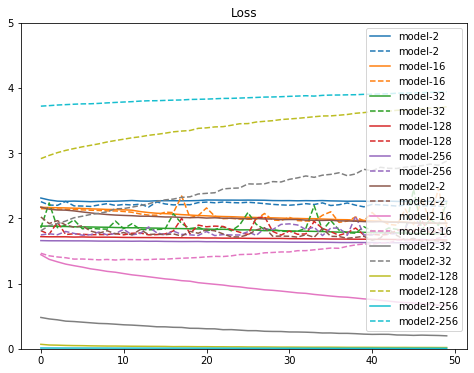

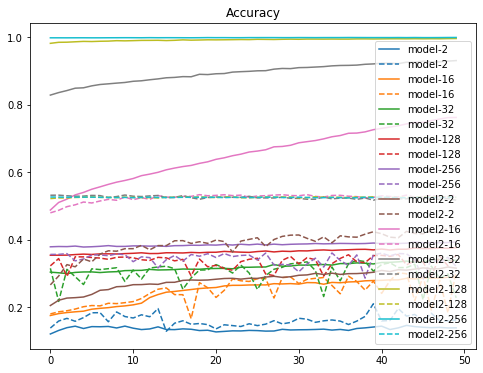

In [12]:
plot_result(results_all)